In [1]:
# imports
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce
from sqlalchemy.orm import mapper, create_session
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_
from sqlalchemy.sql import select
%matplotlib inline

In [2]:
engine = create_engine('sqlite:////ocean/eolson/MEOPAR/obs/DFOOceanProfileDB/salishDB.sqlite')

In [3]:
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
Profs=Base.classes.profiles

In [4]:
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [5]:
sal=case([(Profs.SSAL!=None, Profs.SSAL)], else_=Profs.PSAL)
qsal=case([(Profs.SSAL!=None, Profs.Q_SSAL)], else_=Profs.Q_PSAL)
data=session.query(sal, Profs.NTRA)
print('Q_SAL')
print(session.query(qsal).group_by(qsal).all())
print('Q_NO3')
print(session.query(Profs.Q_NTRA).group_by(Profs.Q_NTRA).all())
NO=[]
S=[]
for m, n in data.all():
    S.append(m)
    NO.append(n)

Q_SAL
[(None,), (Decimal('0E-10'),), (Decimal('1.0000000000'),), (Decimal('2.0000000000'),), (Decimal('3.0000000000'),), (Decimal('4.0000000000'),)]
Q_NO3
[(None,), (Decimal('1.0000000000'),), (Decimal('3.0000000000'),), (Decimal('4.0000000000'),)]


/home/eolson/anaconda3/lib/python3.4/site-packages/sqlalchemy/sql/sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


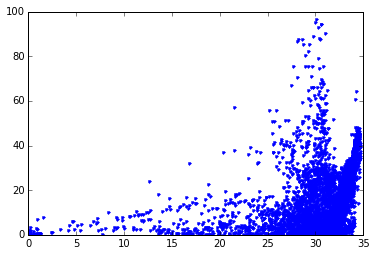

In [6]:
plt.plot(S,NO,'.')
plt.show()

/home/eolson/anaconda3/lib/python3.4/site-packages/sqlalchemy/sql/sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


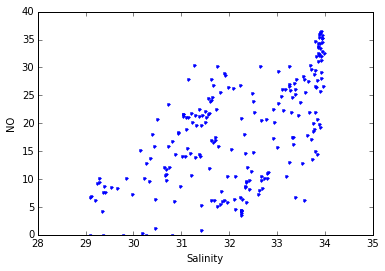

In [7]:
data2=session.query(sal, Profs.NTRA, Profs.TEMP, Profs.LONGITUDE, Profs.OBS_YEAR, Profs.OBS_MONTH, Profs.OBS_DAY).filter(
    and_(
        Profs.LATITUDE > 48.2,
        Profs.LATITUDE < 48.8,
        Profs.LONGITUDE < 125.2,
        Profs.LONGITUDE > 124.2,
        sal != 'NaN',
        Profs.NTRA != 'NaN',
        Profs.TEMP != 'NaN'
        ))
NO=[]
S=[]
T=[]
Lon=[]
Yr=[]
Mon=[]
Day=[]
for m, n, o, p, q, r, s in data2.all():
    S.append(float(m))
    NO.append(float(n))
    T.append(float(o))
    Lon.append(float(p))
    Yr.append(float(q))
    Mon.append(float(r))
    Day.append(float(s))
    
plt.axis([28,35,0,40])
plt.plot(S,NO,'.')
plt.xlabel('Salinity')
plt.ylabel('NO')

In [8]:
NO=np.array(NO)
S=np.array(S)
T=np.array(T)

Lon=np.array(Lon)
Yr=np.array(Yr)
Mon=np.array(Mon)
Day=np.array(Day)

In [9]:
a=np.vstack([T,S,np.ones(len(T))]).T
m = np.linalg.lstsq(a,NO)[0]
mT, mS, m0 = m
print(mT, mS, m0)

-2.22594085829 2.97304465065 -58.3275532242


SSE= 11187.4425182


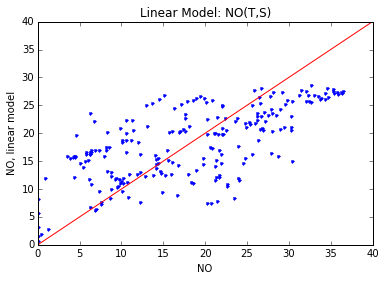

In [10]:
plt.plot(NO,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((NO-np.dot(a,m)),(NO-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S)')
print('SSE=', SSE)
plt.plot(np.array([0,40]), np.array([0, 40]),'r-')

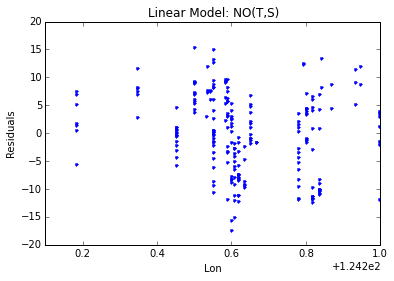

In [11]:
plt.plot(Lon,NO-np.dot(a,m),'.')
plt.xlabel('Lon')
plt.ylabel('Residuals')
plt.title('Linear Model: NO(T,S)')

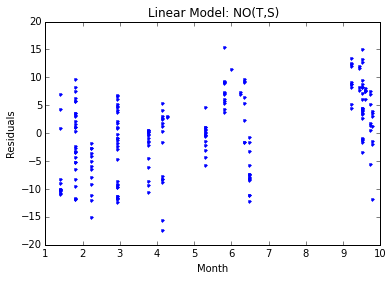

In [12]:
plt.plot(Mon+Day/30.0,NO-np.dot(a,m),'.') # Day/30 = cheat to get approx fraction of month
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.title('Linear Model: NO(T,S)')

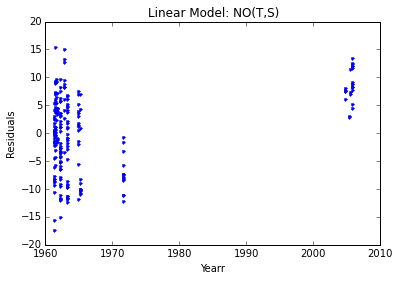

In [13]:
plt.plot(Yr+Mon/12.0+Day/365.0,NO-np.dot(a,m),'.') # Day/30 = cheat to get approx fraction of month
plt.xlabel('Yearr')
plt.ylabel('Residuals')
plt.title('Linear Model: NO(T,S)')

m= [ -3.56543648  48.86014471]
SSE= 13911.2956677


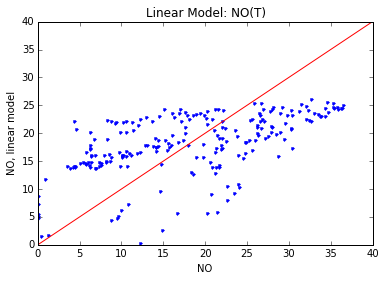

In [14]:
a=np.vstack([T,np.ones(len(T))]).T
m = np.linalg.lstsq(a,NO)[0]
print('m=', m)
plt.plot(NO,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((NO-np.dot(a,m)),(NO-np.dot(a,m)).T)
plt.title('Linear Model: NO(T)')
print('SSE=', SSE)
plt.plot(np.array([0,40]), np.array([0, 40]),'r-')

m= [   4.24368017 -118.39307005]
SSE= 13121.9729808


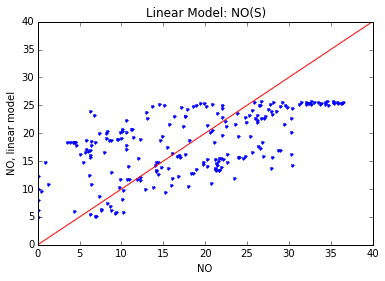

In [15]:
a=np.vstack([S,np.ones(len(T))]).T
m = np.linalg.lstsq(a,NO)[0]
print('m=', m)
plt.plot(NO,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((NO-np.dot(a,m)),(NO-np.dot(a,m)).T)
plt.title('Linear Model: NO(S)')
print('SSE=', SSE)
plt.plot(np.array([0,40]), np.array([0, 40]),'r-')

In [16]:
session.close()
engine.dispose()